In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('Data/dataset-case-iqvia.csv', sep=',')
df['week_dt'] = pd.to_datetime(df['week_dt'])

---

# EDA

In [3]:
df_total = df.groupby('week_dt')['units_qty'].sum().reset_index()
df_total = df_total.sort_values('week_dt')
df_total.set_index('week_dt', inplace=True)

<Axes: xlabel='week_dt'>

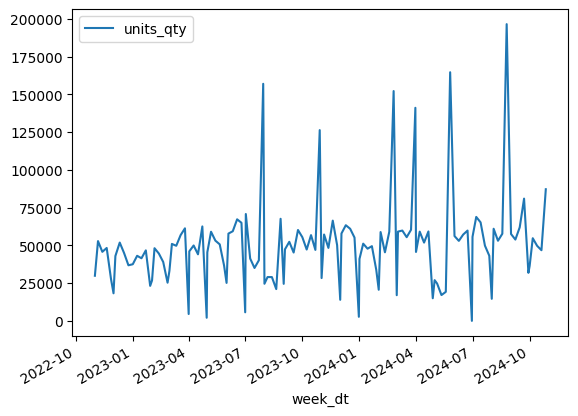

In [4]:
df_total.plot()

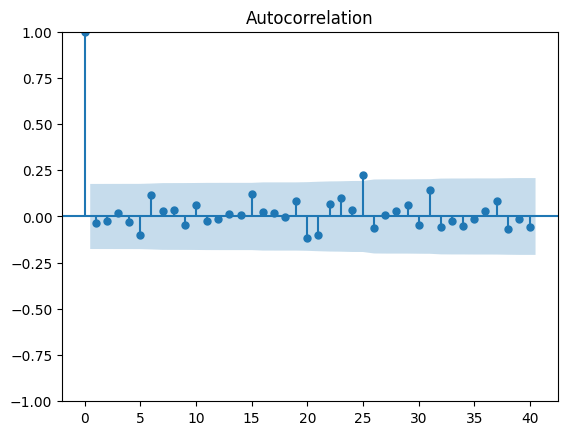

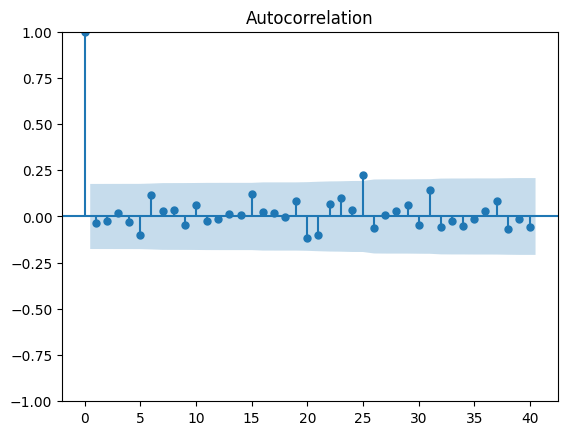

In [5]:
plot_acf(df_total['units_qty'], lags=40)

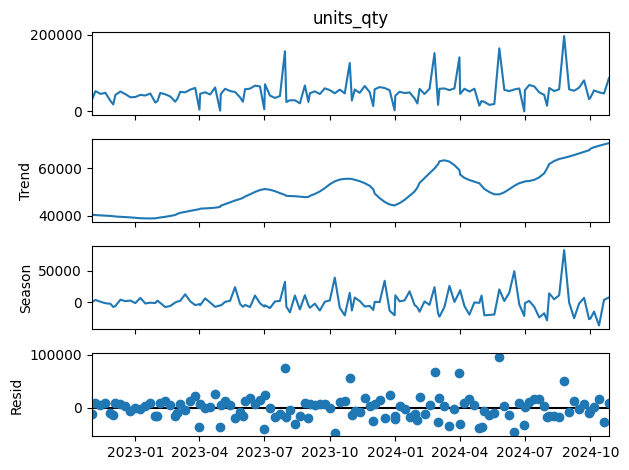

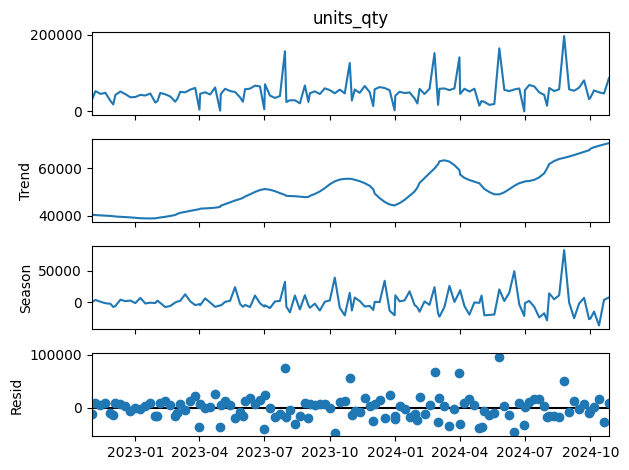

In [6]:
stl = STL(df_total['units_qty'], period=12)
res = stl.fit()
res.plot()

---

# Sarimax - Fornecimento Total

In [7]:
df_total.describe()

,units_qty
count,124.000000
mean,50297.489669
std,29652.901711
min,39.000000
25%,36109.410000
50%,49632.780000
75%,58912.620000
max,196569.800000


In [8]:
for lag in [1, 2, 3, 4, 5, 6, 12]:
    df_total[f'lag_{lag}'] = df_total['units_qty'].shift(lag)

df_total['rolling_mean_3'] = df_total['units_qty'].shift(1).rolling(window=3).mean()
df_total['rolling_mean_6'] = df_total['units_qty'].shift(1).rolling(window=6).mean()
df_total['rolling_std_3'] = df_total['units_qty'].shift(1).rolling(window=3).std()
df_total['rolling_std_6'] = df_total['units_qty'].shift(1).rolling(window=6).std()

df_total.dropna(inplace=True)

In [9]:
y = df_total['units_qty']
exog = df_total[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_6', 'rolling_std_3', 'rolling_std_6']]

model = SARIMAX(y, exog=exog, order=(1,1,1), seasonal_order=(1,1,1,12))
pred = model.fit()

pred.summary()

H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          units_qty   No. Observations:                  112
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1179.502
Date:                            Fri, 02 May 2025   AIC                           2391.003
Time:                                    13:12:34   BIC                           2432.525
Sample:                                         0   HQIC                          2407.803
                                            - 112                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
lag_1              0.0300      0.945      0.032      0.975      -1.822       1.882
lag_2              0.1128      0.361      0.312      0.755      -0.596       0.821
lag_3              0.1328      0.353      0.377      0.706      -0.558       0.824
lag_4              0.0464      0.287      0.162      0.872      -0.516       0.609
lag_5             -0.1110      0.183     -0.608      0.543      -0.469       0.247
lag_6              0.1324      0.211      0.627      0.531      -0.282       0.546
lag_12            -0.1574      0.532     -0.296      0.767      -1.200       0.886
rolling_mean_3     0.0925      0.208      0.445      0.656      -0.315       0.500
rolling_mean_6     0.0580      0.096      0.605      0.545      -0.130       0.246
rolling_std_3     -0.1175      0.447     -0.263      0.793      -0.995       0.760
rolling_std_6     -0.5475      0.883     -0.620      0.535      -2.279       1.184
ar.L1             -0.0423      1.202     -0.035      0.972      -2.399       2.314
ma.L1             -0.9159      0.163     -5.634      0.000      -1.234      -0.597
ar.S.L12          -0.0310      0.677     -0.046      0.964      -1.359       1.297
ma.S.L12          -0.7156      0.337     -2.125      0.034      -1.376      -0.056
sigma2          1.848e+09   3.87e-10   4.78e+18      0.000    1.85e+09    1.85e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               131.73
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             1.57
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.21e+36. Standard errors may be unstable.
"""

In [10]:
df_total['forecast'] = pred.predict(start=0, end=len(df_total)-1, exog=exog)

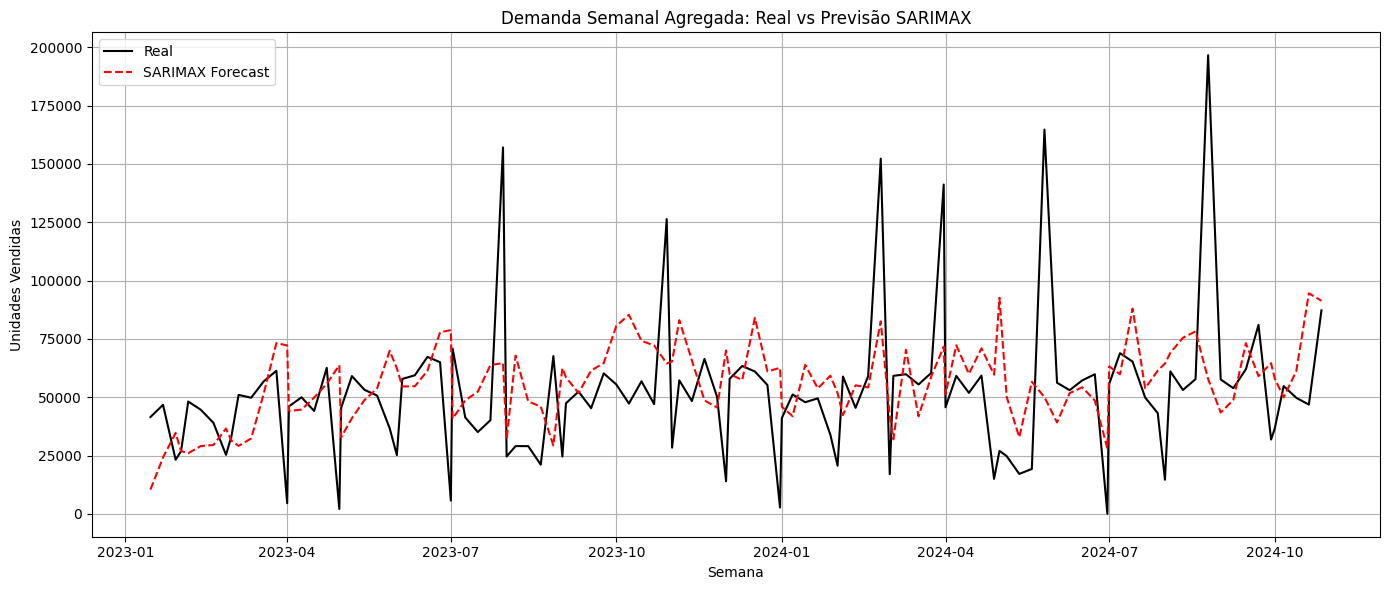

In [11]:
plt.figure(figsize=(14,6))
plt.plot(df_total.index, df_total['units_qty'], label='Real', color='black')
plt.plot(df_total.index, df_total['forecast'], label='SARIMAX Forecast', color='red', linestyle='--')
plt.title('Demanda Semanal Agregada: Real vs Previsão SARIMAX')
plt.xlabel('Semana')
plt.ylabel('Unidades Vendidas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Sarimax - Região e Distribuidor

In [12]:
df_grouped = df.groupby(['week_dt', 'dsupp_id', 'region_nm'])['units_qty'].sum().reset_index()

In [13]:
def sarimax_group(dsupp_id, region_nm):
    df_filtrado = df_grouped[
        (df_grouped['dsupp_id'] == dsupp_id) &
        (df_grouped['region_nm'] == region_nm)
    ].copy()

    
    df_filtrado = df_filtrado.sort_values('week_dt')
    
    df_filtrado.set_index('week_dt', inplace=True)

    for lag in [1, 2, 3, 4, 5, 6, 12]:
        df_filtrado[f'lag_{lag}'] = df_filtrado['units_qty'].shift(lag)
    
    df_filtrado['rolling_mean_3'] = df_filtrado['units_qty'].shift(1).rolling(window=3).mean()
    df_filtrado['rolling_mean_6'] = df_filtrado['units_qty'].shift(1).rolling(window=6).mean()
    df_filtrado['rolling_std_3'] = df_filtrado['units_qty'].shift(1).rolling(window=3).std()
    df_filtrado['rolling_std_6'] = df_filtrado['units_qty'].shift(1).rolling(window=6).std()
    
    df_filtrado.dropna(inplace=True)

    y = df_filtrado['units_qty']
    exog = df_filtrado[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_6', 'rolling_std_3', 'rolling_std_6']]

    model = SARIMAX(y, exog=exog, order=(1,1,1), seasonal_order=(1,1,1,12))
    pred = model.fit()

    df_filtrado['forecast'] = pred.predict(start=0, end=len(df_filtrado)-1, exog=exog)

    plt.figure(figsize=(14,5))
    plt.plot(df_filtrado.index, df_filtrado['units_qty'], label='Real', color='black')
    plt.plot(df_filtrado.index, df_filtrado['forecast'], label='Previsão', color='red', linestyle='--')
    plt.title(f'Demanda Real vs. Prevista - Distribuidor {dsupp_id} | Região {region_nm}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pred

H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


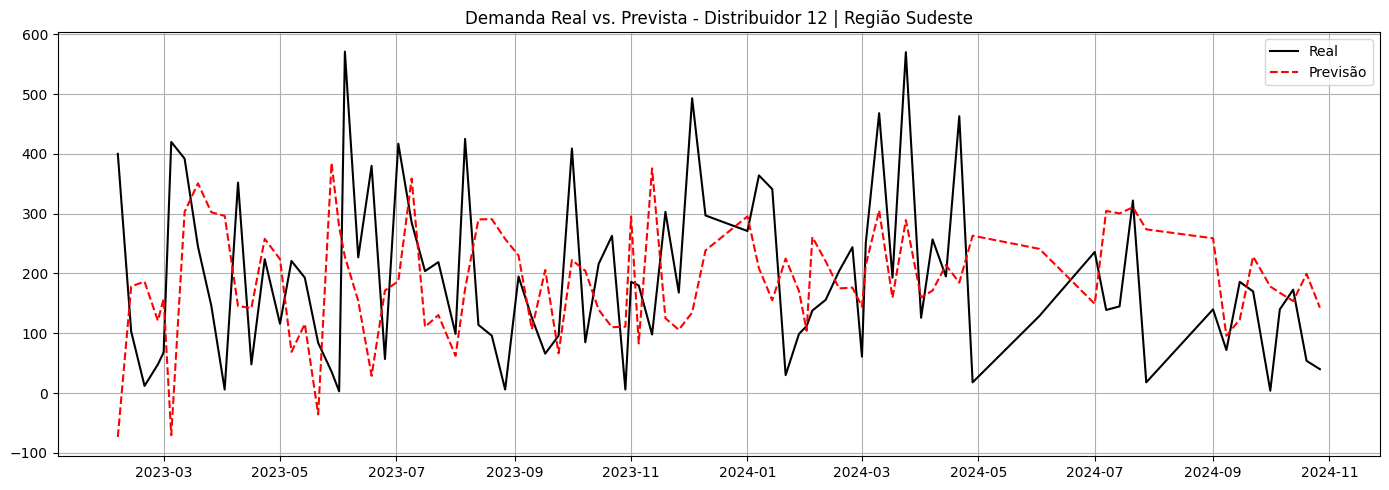

In [14]:
model = sarimax_group(12, 'Sudeste')